In [1]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

from entities.entity import Entity
from entities.animal import Animal 
from entities.microphone import MicrophoneStation

SPEED_OF_SOUND = 343 # m/s

In [2]:
# Set an animal true location
truth_animal = Animal()
truth_animal.setLLA((-48.0,134.0,10.0))
print(f'True animal LLA', truth_animal.getLLA())

# set the location of three sensors around this animal
test_sensor_1 = MicrophoneStation(lla=(-48.0,133.99,10.0))
print(f'Sensor 1    LLA', test_sensor_1.getLLA())

test_sensor_2 = MicrophoneStation(lla=(-48.0,134.05,10.0))
print(f'Sensor 2    LLA', test_sensor_2.getLLA())

test_sensor_3 = MicrophoneStation(lla=(-48.01,134.0,10.0))
print(f'Sensor 3    LLA', test_sensor_3.getLLA())

test_sensor_4 = MicrophoneStation(lla=(-48.01,134.04,10.0))
print(f'Sensor 4    LLA', test_sensor_3.getLLA())

print("distance 1", test_sensor_1.distance(truth_animal))
print("distance 2", test_sensor_2.distance(truth_animal))
print("distance 3", test_sensor_3.distance(truth_animal))
print("distance 4", test_sensor_4.distance(truth_animal))

# Sphere centers and radii and travel times
p1 = np.array(test_sensor_1.getECEF())
r1 = test_sensor_1.distance(truth_animal)
sound_travel_time_1 = r1 / SPEED_OF_SOUND

p2 = np.array(test_sensor_2.getECEF())
r2 = test_sensor_2.distance(truth_animal)
sound_travel_time_2 = r2 / SPEED_OF_SOUND

p3 = np.array(test_sensor_3.getECEF())
r3 = test_sensor_3.distance(truth_animal)
sound_travel_time_3 = r3 / SPEED_OF_SOUND

p4 = np.array(test_sensor_4.getECEF())
r4 = test_sensor_4.distance(truth_animal)
sound_travel_time_4 = r4 / SPEED_OF_SOUND

print("sound travel time 1", sound_travel_time_1)
print("sound travel time 2", sound_travel_time_2)
print("sound travel time 3", sound_travel_time_3)
print("sound travel time 4", sound_travel_time_4)

# Determine the closest sensor i.e. with smallest travel time and set time to zero
min_time = np.min([sound_travel_time_1,sound_travel_time_2,sound_travel_time_3,sound_travel_time_4])

# Determine the observed trigger times with the closest one set to zero
st_obs_1 = sound_travel_time_1 - min_time
st_obs_2 = sound_travel_time_2 - min_time
st_obs_3 = sound_travel_time_3 - min_time
st_obs_4 = sound_travel_time_4 - min_time

print("sound trigger time 1", st_obs_1)
print("sound trigger time 2", st_obs_2)
print("sound trigger time 3", st_obs_3)
print("sound trigger time 4", st_obs_4)

True animal LLA (-48.0, 134.0, 10.0)
Sensor 1    LLA (-48.0, 133.99, 10.0)
Sensor 2    LLA (-48.0, 134.05, 10.0)
Sensor 3    LLA (-48.01, 134.0, 10.0)
Sensor 4    LLA (-48.01, 134.0, 10.0)
distance 1 746.2547025302385
distance 2 3731.2733989899125
distance 3 1111.9059424847765
distance 4 3185.1137618235216
sound travel time 1 2.17566968667708
sound travel time 2 10.878348102011406
sound travel time 3 3.2417082871276284
sound travel time 4 9.286045952838256
sound trigger time 1 0.0
sound trigger time 2 8.702678415334326
sound trigger time 3 1.0660386004505482
sound trigger time 4 7.110376266161175


In [3]:
def solve_animal_lla(sensor_1,sensor_2,sensor_3,sensor_4,st_est_1,st_est_2,st_est_3,st_est_4):
    # grid search
    estimate_animal = Animal()
    best_err = 100000000

    for lat in np.arange(-48.1,-47.9,0.01):
        for lon in np.arange(133.9,134.1,0.01):
            
            # guess it is here...
            estimate_animal.setLLA((lat, lon, 10.0))
            
            # so calculate the times given that guess
            r1 = sensor_1.distance(estimate_animal)
            s_1 = r1 / SPEED_OF_SOUND

            r2 = sensor_2.distance(estimate_animal)
            s_2 = r2 / SPEED_OF_SOUND

            r3 = sensor_3.distance(estimate_animal)
            s_3 = r3 / SPEED_OF_SOUND
            
            r4 = sensor_4.distance(estimate_animal)
            s_4 = r4 / SPEED_OF_SOUND        
            
            # Determine the closest sensor i.e. with smallest travel time and set time to zero
            min_time = np.min([s_1,s_2,s_3,s_4])

            # Determine the trigger times
            st_est_1 = s_1 - min_time
            st_est_2 = s_2 - min_time
            st_est_3 = s_3 - min_time
            st_est_4 = s_4 - min_time       
            
            # calculate the error with times observed
            err = abs(st_obs_1-st_est_1) + \
                  abs(st_obs_2-st_est_2) + \
                  abs(st_obs_3-st_est_3) + \
                  abs(st_obs_4-st_est_4) 
                
            if err < best_err:
                best_err = err
                best_lat,best_lon=lat,lon
                print(f'New best lat: {lat} lon: {lon} absolute error in arrival times: {err}')
                
    return best_lat,best_lon
                
# using only the information about sensors and observed trigger times
lat,lon = solve_animal_lla(
    test_sensor_1,test_sensor_2,test_sensor_3,test_sensor_4,
    st_obs_1,st_obs_2,st_obs_3,st_obs_4)  

print(f'Estimated Animal lat: {lat} lon: {lon}')
    

New best lat: -48.1 lon: 133.9 absolute error in arrival times: 4.777433396892862
New best lat: -48.09 lon: 133.9 absolute error in arrival times: 4.535763480085771
New best lat: -48.080000000000005 lon: 133.9 absolute error in arrival times: 4.2397024151799325
New best lat: -48.07000000000001 lon: 133.9 absolute error in arrival times: 3.8774259423875157
New best lat: -48.06000000000001 lon: 133.91 absolute error in arrival times: 3.8274754506041346
New best lat: -48.00000000000002 lon: 133.99999999999991 absolute error in arrival times: 1.0076472989339891e-10
Estimated Animal lat: -48.00000000000002 lon: 133.99999999999991


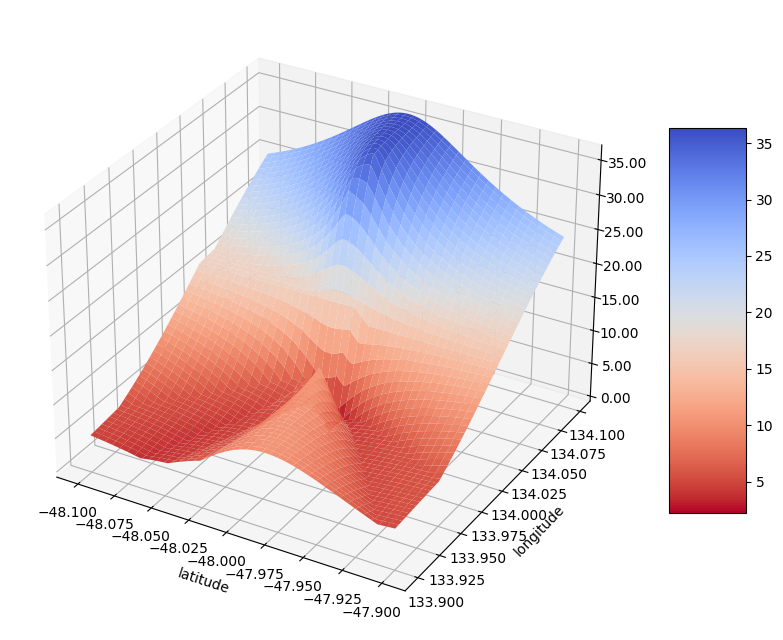

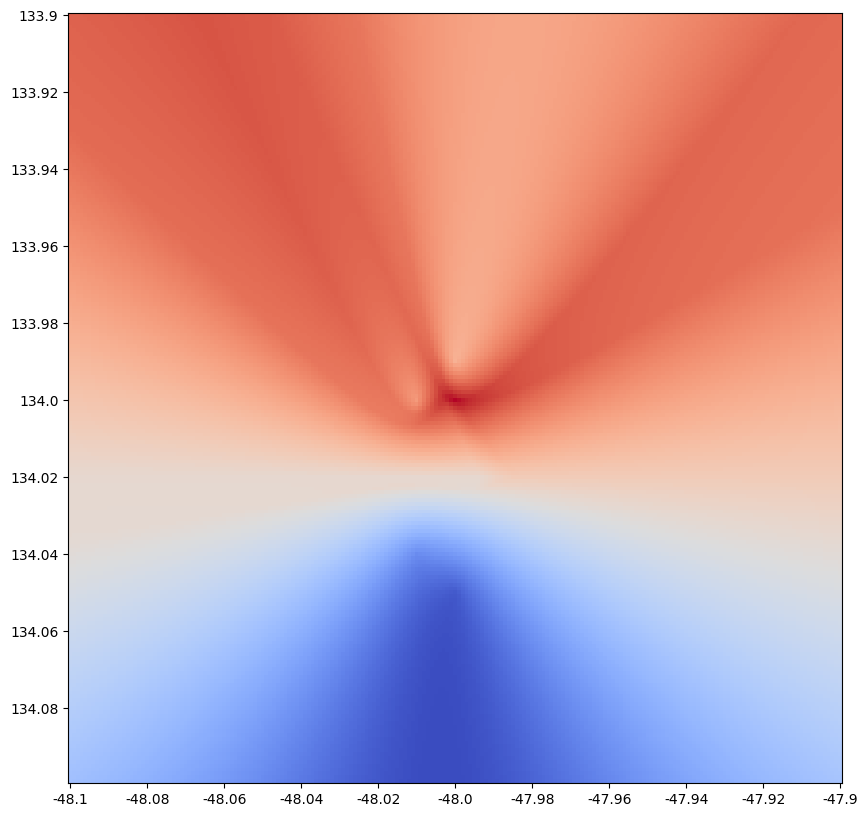

In [17]:
def plot_animal_lla(sensor_1,sensor_2,sensor_3,sensor_4,st_est_1,st_est_2,st_est_3,st_est_4):
    # grid search
    estimate_animal = Animal()
    best_err = 100000000
    lat_min_max=(-48.1,-47.9)
    lon_min_max=(133.9,134.1)
    lat_range = np.arange(lat_min_max[0],lat_min_max[1],0.001)
    lon_range = np.arange(lon_min_max[0],lon_min_max[1],0.001)
    errs = np.zeros(shape=(len(lon_range), len(lat_range)))

    for ilat, lat in enumerate(lat_range):
        for ilon, lon in enumerate(lon_range):
            
            # guess it is here...
            estimate_animal.setLLA((lat, lon, 10.0))
            
            # so calculate the times given that guess
            r1 = sensor_1.distance(estimate_animal)
            s_1 = r1 / SPEED_OF_SOUND

            r2 = sensor_2.distance(estimate_animal)
            s_2 = r2 / SPEED_OF_SOUND

            r3 = sensor_3.distance(estimate_animal)
            s_3 = r3 / SPEED_OF_SOUND
            
            r4 = sensor_4.distance(estimate_animal)
            s_4 = r4 / SPEED_OF_SOUND        
            
            # Determine the closest sensor i.e. with smallest travel time and set time to zero
            min_time = np.min([s_1,s_2,s_3,s_4])

            # Determine the trigger times
            st_est_1 = s_1 - min_time
            st_est_2 = s_2 - min_time
            st_est_3 = s_3 - min_time
            st_est_4 = s_4 - min_time       
            
            # calculate the error with times observed
            err = abs(st_obs_1-st_est_1) + \
                  abs(st_obs_2-st_est_2) + \
                  abs(st_obs_3-st_est_3) + \
                  abs(st_obs_4-st_est_4) 
                  
            errs[ilon, ilat] = err
                
            if err < best_err:
                best_err = err
                best_lat,best_lon=lat,lon
                # print(f'New best lat: {lat} lon: {lon} absolute error in arrival times: {err}')

    # Plot the surface.
    fig, ax = plt.subplots(figsize=(10,10),subplot_kw={"projection": "3d"})
    X, Y = np.meshgrid(lat_range, lon_range)
    Z = errs
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm_r,
                        linewidth=0, antialiased=True)

    # Customize the z axis.
    ax.zaxis.set_major_formatter('{x:.02f}')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel("latitude")
    ax.set_ylabel("longitude")
    
    plt.show()
    
    # Plot as a heat map
    plt.figure(figsize=(10,10))
    plt.imshow(Z, cmap=cm.coolwarm_r, interpolation='none')
    lat_fig_range = np.arange(lat_min_max[0],lat_min_max[1],0.02)
    lon_fig_range = np.arange(lon_min_max[0],lon_min_max[1],0.02)  
    plt.xticks(ticks = range(0,len(lat_range),20), labels=np.round(lat_fig_range,2))
    plt.yticks(ticks = range(0,len(lon_range),20), labels=np.round(lon_fig_range,2))
    plt.show()
    
# using only the information about sensors and observed trigger times
plot_animal_lla(
    test_sensor_1,test_sensor_2,test_sensor_3,test_sensor_4,
    st_obs_1,st_obs_2,st_obs_3,st_obs_4) 